In [1]:
# These are the import statments necessary 
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


np.random.seed(42)

#### The following functions are used to compute technical indicators ###
# This function computes the rsi 
def compute_rsi(series, window=14):
    delta = series.diff() # calculates the difference between each price point and the previous price poin
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean() #  identifies the positive changes (gains) in the price
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean() # identifies the negative changes in the price
    rs = gain / loss # relative strength 
    return 100 - (100 / (1 + rs)) # rsi calculation

# This function computes the MACD or moving average convergence divergence 
def compute_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean() # calculates the fast ema
    ema_slow = series.ewm(span=slow, adjust=False).mean() # calculates the slow ema
    macd = ema_fast - ema_slow # calculates the MACD line
    signal_line = macd.ewm(span=signal, adjust=False).mean() # calulates the signal line
    return macd, signal_line

# This function calculates the stochastic oscillator, which is a momentum indicator
# that compares a particular closing price of a security to a range of its prices over a certain period of time
def compute_stochastic_oscillator(high, low, close, k_period=14, d_period=3):
    lowest_low = low.rolling(window=k_period).min() 
    highest_high = high.rolling(window=k_period).max()
    stoch_k = 100 * (close - lowest_low) / (highest_high - lowest_low)
    stoch_d = stoch_k.rolling(window=d_period).mean()
    return stoch_k, stoch_d

# This function downloads the data from yfinance and adds the features to the data
# It also downloads the macro indicators and adds them to the data
def add_features_with_macro(ticker="^GSPC", start="2020-01-30", end="2024-01-01", prediction_horizon=5, big_move_threshold=0.005):
    df = yf.download(ticker, start=start, end=end)

    # These are the macro indicators we are using 
    vix = yf.download('^VIX', start=start, end=end)
    tnx = yf.download('^TNX', start=start, end=end)

    # This cleans the columns 
    df.columns = [col if isinstance(col, str) else col[0] for col in df.columns]

    # We created a 'mid' column, which is the average of the high and low prices
    df['Mid'] = (df['High'] + df['Low']) / 2
    df['Return'] = df['Close'].pct_change()
    df['Mid_Return'] = df['Mid'].pct_change()

    # These are the technical indicators we are using
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Volatility'] = df['Return'].rolling(window=10).std()
    df['Momentum'] = df['Close'] - df['Close'].shift(5)
    df['RSI'] = compute_rsi(df['Close'])
    df['MACD'], df['MACD_signal'] = compute_macd(df['Close'])
    df['Stoch_K'], df['Stoch_D'] = compute_stochastic_oscillator(df['High'], df['Low'], df['Close'])

    ## These are the macro indicators 
    df['VIX_Close'] = vix['Close']
    df['TNX_Close'] = tnx['Close']

    # This calculates the future return of a stock (or other asset) based on the Close price, with a given prediction horizon.
    df['Future_Return'] = df['Close'].shift(-prediction_horizon) / df['Close'] - 1 

    # This part of the code is creating a multi-class target variable with three classes, -1, 0, and 1. 
    df['Target'] = np.where(df['Future_Return'] > big_move_threshold, 1,
                    np.where(df['Future_Return'] < -big_move_threshold, -1, 0))
    
    # These columns are used to create the features for the model
    df['X_MA5'] = (df['Close'] - df['MA5']) / df['Close']
    df['X_MA10'] = (df['Close'] - df['MA10']) / df['Close']
    df['X_MA20'] = (df['Close'] - df['MA20']) / df['Close']
    df['X_MA5_10'] = (df['MA5'] - df['MA10']) / df['Close']
    df['X_MA10_20'] = (df['MA10'] - df['MA20']) / df['Close']
    df['X_Volatility'] = df['Volatility']
    df['X_Momentum'] = df['Momentum']
    df['X_Return'] = df['Return']
    df['X_Return_5'] = df['Return'].rolling(5).sum()
    df['X_VOL_CHG'] = df['Volume'].pct_change(5)
    df['X_RSI'] = df['RSI']
    df['X_MACD'] = df['MACD']
    df['X_MACD_signal'] = df['MACD_signal']
    df['X_Stoch_K'] = df['Stoch_K']
    df['X_Stoch_D'] = df['Stoch_D']
    df['X_VIX'] = df['VIX_Close']
    df['X_TNX'] = df['TNX_Close']

    return df  

# The get_X and get_y functions are helper functions that extract features and labels from the data
def get_X(data):
    feature_columns = [col for col in data.columns if col.startswith('X_')]
    return data[feature_columns].values
def get_y(data):
    """Return target variable y, mapped to [0, 1, 2]"""
    y = data.Target.values
    return np.where(y == -1, 0, np.where(y == 0, 1, 2))

df = add_features_with_macro()
df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume"])

/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# This is the strategy class that uses the SVC model to predict the target variable and trade the stock
class RandomForestStrategy(Strategy):
    n_estimators = 100
    price_delta = 0.01
    lookback_window = 200

    def init(self):
        # Taking the features from the data 
        full_df = add_features_with_macro(ticker="^GSPC").fillna(method='ffill').fillna(method='bfill')
        self.all_data = full_df.loc[self.data.df.index.intersection(full_df.index)]
        
        # Extract features
        self.features = [col for col in self.all_data.columns if col.startswith("X_")]
        
        # Initialize model
        self.model = RandomForestClassifier(
            n_estimators=self.n_estimators,
            max_depth=5,
            min_samples_split=10,
            random_state=42
        )
        
        # Prediction tracking
        self.predictions = []
        self.actuals = []

    def next(self):
        # Current position in the backtest
        current_idx = len(self.data) - 1
        
        # Safety check - make sure we have enough data
        if current_idx < self.lookback_window:
            return
            
        # Get current data index
        current_candle_time = self.data.index[-1]
        
        try:
            # Find corresponding index in our all_data DataFrame
            idx_in_all_data = self.all_data.index.get_indexer([current_candle_time])[0]
            
            # Check if valid index found
            if idx_in_all_data < 0 or idx_in_all_data < self.lookback_window:
                return
                
            # Safe slicing with loc instead of iloc
            start_idx = self.all_data.index[idx_in_all_data - self.lookback_window + 1]
            end_idx = self.all_data.index[idx_in_all_data]
            train_data = self.all_data.loc[start_idx:end_idx].iloc[:-1]  # All but last point
            test_data = self.all_data.loc[end_idx:end_idx]  # Just the last point
            
            # Check if we have enough data
            if len(train_data) < self.lookback_window // 2:
                return
                
            # Extract features and target
            X_train = train_data[self.features].values
            y_train = train_data["Target"].values
            X_test = test_data[self.features].values
            y_true = test_data["Target"].values[0]
            
            # Train model dynamically on each call
            self.model.fit(X_train, y_train)
            
            # Make prediction
            prediction = self.model.predict(X_test)[0]
                
            # Log predictions and labels
            if prediction in [-1, 0, 1]:
                self.predictions.append(prediction)
                self.actuals.append(int(y_true))
                
            # Trade execution with take-profit and stop-loss
            close = self.data.Close[-1]
            tp_long = close * (1 + self.price_delta)
            sl_long = close * (1 - self.price_delta)
            tp_short = close * (1 - self.price_delta)
            sl_short = close * (1 + self.price_delta)
            
            # Trading logic
            if prediction == 1:
                if not self.position.is_long:
                    self.position.close()
                    self.buy(tp=tp_long, sl=sl_long)
                    
            elif prediction == -1:
                if not self.position.is_short:
                    self.position.close()
                    self.sell(tp=tp_short, sl=sl_short)
                    
            # Risk management with trailing stop
            for trade in self.trades:
                if self.data.index[-1] - trade.entry_time > pd.Timedelta(days=5):
                    if trade.is_long:
                        trade.sl = max(trade.sl, trade.entry_price)
                    else:
                        trade.sl = min(trade.sl, trade.entry_price)
                        
        except (IndexError, KeyError) as e:
            # Handle exceptions gracefully to avoid breaking the backtest
            pass

In [3]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_strategy(y_true, y_pred):

    print("Evaluation Metrics")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Precision (macro):", round(precision_score(y_true, y_pred, average='macro'), 4))
    print("F1 Score (macro):", round(f1_score(y_true, y_pred, average='macro'), 4))

    cm = confusion_matrix(y_true, y_pred, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Down (-1)', 'Neutral (0)', 'Up (1)'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

In [6]:
bt = Backtest(df, RandomForestStrategy, cash=10_000, commission=.0002, margin = 0.05)
backtest = bt.run()
backtest

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/bg/6x82p8q55dxf8pb_c34j03mm0000gn/T/ipykernel_45856/2145784034.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_df = add_features_with_macro(ticker="^GSPC").fillna(method='ffill').fillna(method='bfill')


AttributeError: 'RandomForestStrategy' object has no attribute 'train_size'

📈 Evaluation Metrics
Accuracy: 0.5609
Precision (macro): 0.5297
F1 Score (macro): 0.5304


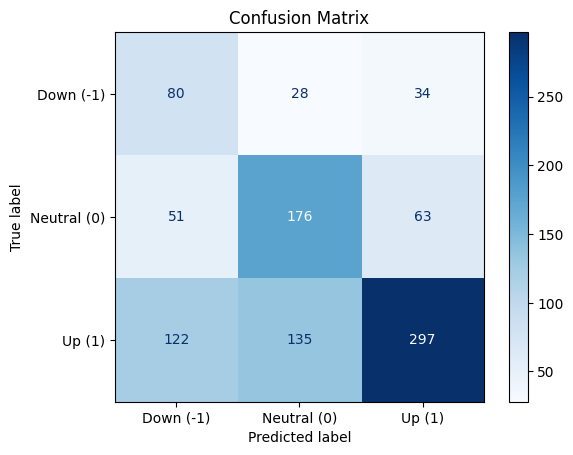

In [57]:
predictions = backtest._strategy.predictions
actuals = backtest._strategy.actuals
evaluate_strategy(predictions, actuals)

In [58]:
bt.plot()

/Users/aroncheng/backtest-env/lib/python3.9/site-packages/backtesting/_plotting.py:701: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/Users/aroncheng/backtest-env/lib/python3.9/site-packages/backtesting/_plotting.py:701: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p2521', ...)